# Dependencies

In [1]:
import qgrid
from tqdm import tqdm
import pandas as pd
import numpy as np
from pandas import *
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from collections import Counter

from pylab import mpl
from sklearn import metrics

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import sys

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
train = pd.read_csv('./data/train.psv', sep='|')

In [3]:
len(train)

1552265

In [4]:
sampl = pd.read_csv('./data/trainingB/p100016.psv', sep='|')
#sampl_qd = qgrid.show_grid(sampl, show_toolbar = True)
print(sampl['SepsisLabel'].tail(1))
sampl['HCO3'].head()

270    1
Name: SepsisLabel, dtype: int64


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: HCO3, dtype: float64

In [5]:
sampl.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

# Exploration

### 提取所有被判断患病的病人id

In [3]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')
list_a = []
list_b = []
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv(
        './data/trainingA/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) != 0:
        list_a.append(csv)

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv(
        './data/trainingB/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) != 0:
        list_b.append(csv)

In [4]:
list_a = sorted(list_a)
list_b = sorted(list_b)
normal_a = sorted(list(set(listdir('./data/trainingA/')) - set(list_a)))
normal_b = sorted(list(set(listdir('./data/trainingB/')) - set(list_b)))
patient_a = list_a
patient_b = list_b

##### 单个病人数据查看

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')


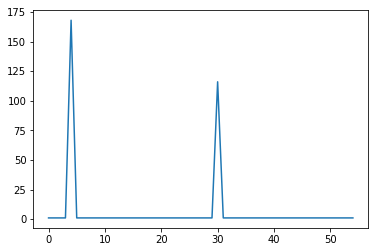

In [13]:
csv = 'p002123.psv'
print(tmp.columns)
tmp = pd.read_csv(
    '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
plt.plot(list(range(len(tmp))), tmp['Glucose'].fillna(1), label='broadcast')

### 正负样本比例

In [27]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

sick_A = [0, 0]

for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) > 0:
        sick_A[1] += 1
    else:
        sick_A[0] += 1

sick_B = [0, 0]

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) > 0:
        sick_B[1] += 1
    else:
        sick_B[0] += 1

Text(0.5, 1.0, '01 distribution for Sepsis')

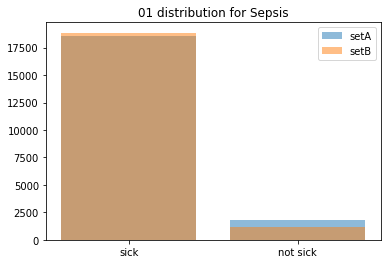

In [28]:
pA = plt.bar(['sick', 'not sick'], sick_A, label='line', alpha=0.5)
pB = plt.bar(['sick', 'not sick'], sick_B, label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title("01 distribution for Sepsis")

### 正样本分析

##### 化验数据比例

In [23]:
a_traincsv = list_a
b_traincsv = list_b

chemdata_A_sick = {}
for i in range(11):
    chemdata_A_sick[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A_sick[per] += 1

chemdata_B_sick = {}
for i in range(11):
    chemdata_B_sick[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B_sick[per] += 1

Text(0.5, 1.0, 'laboratory data percentage in single sick person')

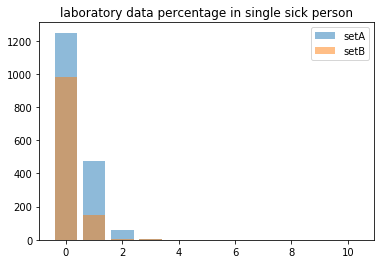

In [26]:
#chemdata_A_sick = pd.DataFrame.from_dict(chemdata_A_sick, orient='index')
#chemdata_B_sick = pd.DataFrame.from_dict(chemdata_B_sick, orient='index')
pA = plt.bar(chemdata_A_sick.index*10,
             chemdata_A_sick[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B_sick.index*10,
             chemdata_B_sick[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in single patient")

###### 负样本对比

In [7]:
a_traincsv = list(set(listdir('./data/trainingA/')) - set(list_a))
b_traincsv = list(set(listdir('./data/trainingB/')) - set(list_b))

chemdata_A_normal = {}
for i in range(11):
    chemdata_A_normal[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A_normal[per] += 1

chemdata_B_normal = {}
for i in range(11):
    chemdata_B_normal[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B_normal[per] += 1

Text(0.5, 1.0, 'laboratory data percentage in single normal person')

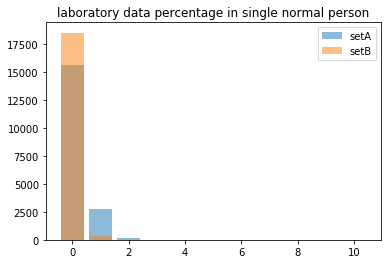

In [8]:
chemdata_A_normal = pd.DataFrame.from_dict(chemdata_A_normal, orient='index')
chemdata_B_normal = pd.DataFrame.from_dict(chemdata_B_normal, orient='index')
pA = plt.bar(chemdata_A_normal.index*10,
             chemdata_A_normal[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B_normal.index*10,
             chemdata_B_normal[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in single normal person")

##### 生命体征分析

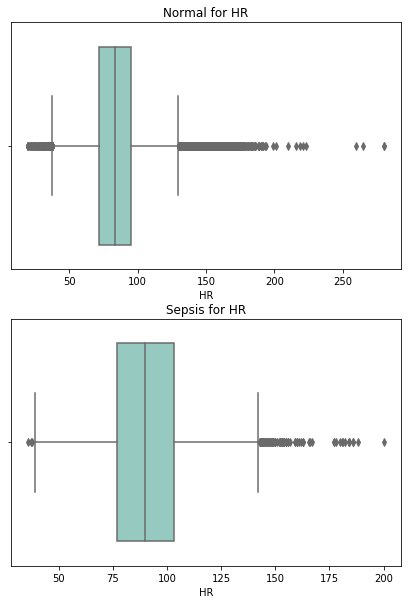

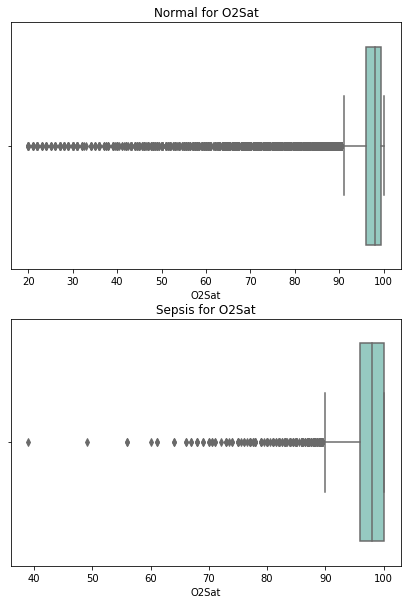

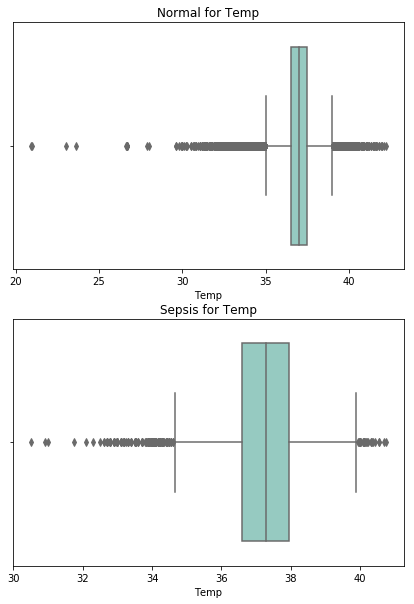

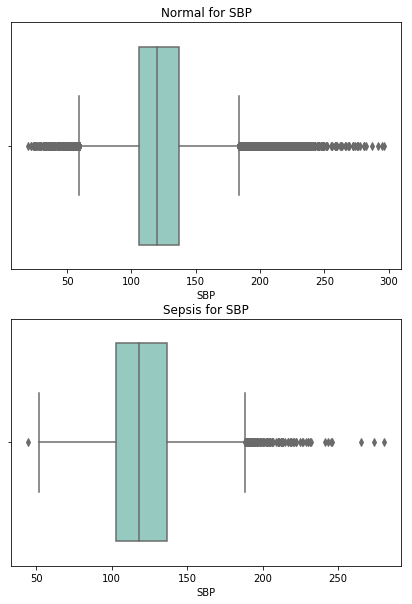

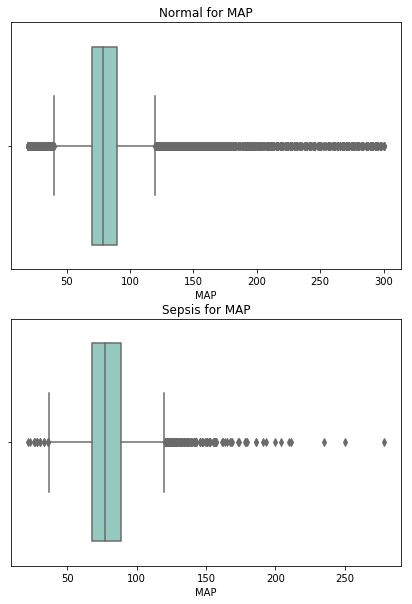

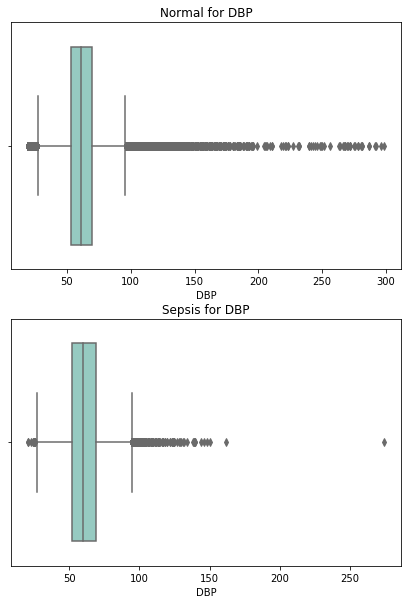

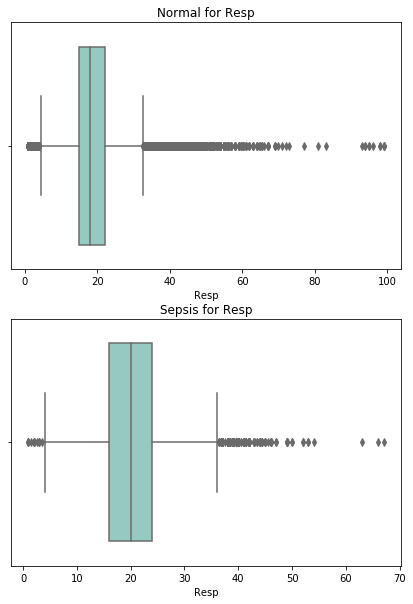

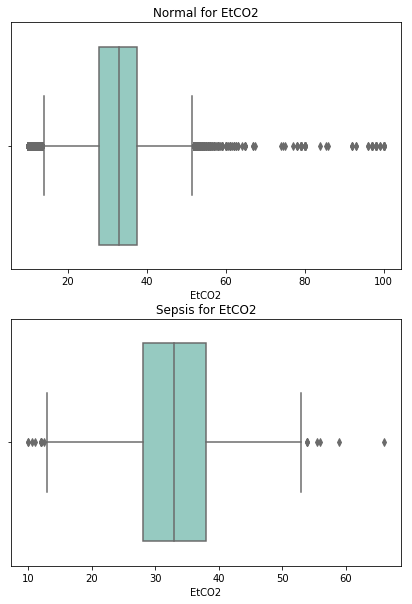

In [26]:
vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
for i, var in enumerate(vital_signs):
    temp = train[[var, 'SepsisLabel']].dropna()
    temp1 = temp[temp['SepsisLabel'] == 0]
    temp2 = temp[temp['SepsisLabel'] == 1]
    fig, ax = plt.subplots(2, 1, figsize=(7, 10))

    sns.boxplot(temp1[var], ax=ax[0], palette='Set3')
    sns.boxplot(temp2[var], ax=ax[1], palette='Set3')
    ax[0].set_title("Normal for " + var)
    ax[1].set_title("Sepsis for " + var)

### 化验数据分析

##### 化验数据比例

In [7]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

chemdata_A = {}
for i in range(11):
    chemdata_A[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A[per] += 1

chemdata_B = {}
for i in range(11):
    chemdata_B[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B[per] += 1

TypeError: unsupported operand type(s) for +: 'int' and 'str'

Text(0.5, 1.0, 'laboratory data percentage in one patient')

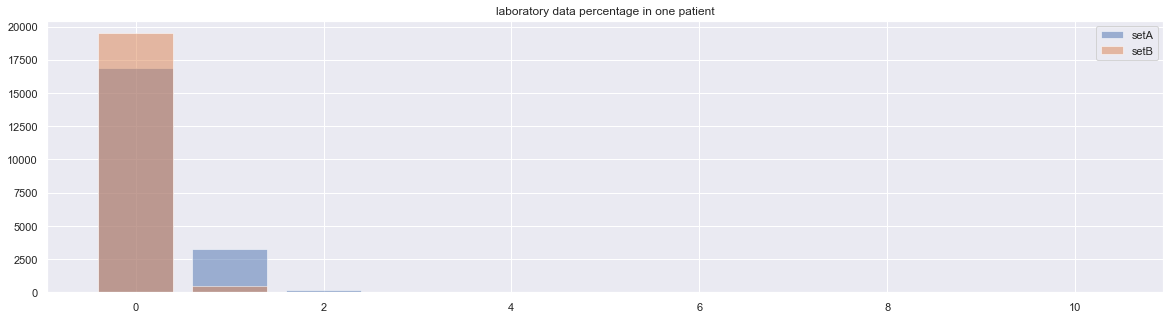

In [299]:
#chemdata_A = pd.DataFrame.from_dict(chemdata_A, orient='index')
#chemdata_B = pd.DataFrame.from_dict(chemdata_B, orient='index')
pA = plt.bar(chemdata_A.index*10, chemdata_A[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B.index*10, chemdata_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in one patient")

### 单病人观察时间长度分布

In [122]:
a_traincsv = patient_a
b_traincsv = patient_b

distributionA = {}
for i in range(500):
    distributionA[i] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv)
    distributionA[len(tmp)] += 1

distributionB = {}
for i in range(500):
    distributionB[i] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv)
    distributionB[len(tmp)] += 1

Text(0.5, 1.0, 'length distribution of patient set ')

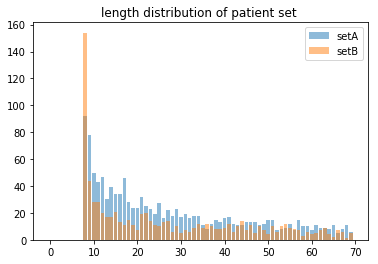

In [126]:
length_A = pd.DataFrame.from_dict(distributionA, orient='index')
length_B = pd.DataFrame.from_dict(distributionB, orient='index')
pA = plt.bar(length_A.index[:70], length_A[0][:70], label='line', alpha=0.5)
pB = plt.bar(length_B.index[:70], length_B[0][:70], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title("length distribution of patient set ")

### 病人平均发病时间

In [18]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

distributionA = {}
for i in range(500):
    distributionA[i] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if int(tmp['SepsisLabel'].tail(1)) == 1:
        distributionA[len(tmp[tmp['SepsisLabel'] == 0])] += 1

distributionB = {}
for i in range(500):
    distributionB[i] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if int(tmp['SepsisLabel'].tail(1)) == 1:
        distributionB[len(tmp[tmp['SepsisLabel'] == 0])] += 1


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, 'Time befored judged as sepsis ')

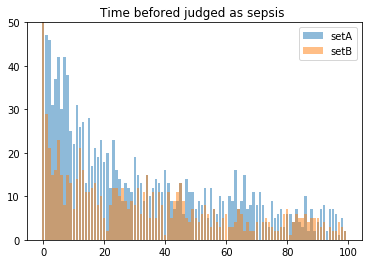

In [24]:
length_A = pd.DataFrame.from_dict(distributionA, orient='index')
length_B = pd.DataFrame.from_dict(distributionB, orient='index')
pA = plt.bar(length_A.index[:100], length_A[0][:100], label='line', alpha=0.5)
pB = plt.bar(length_B.index[:100], length_B[0][:100], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.ylim(ymax=50)
plt.title("Time befored judged as sepsis ")

### 单病人被判断患病的时间段占比

In [102]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

one_percentage_A = {}
for i in range(11):
    one_percentage_A[i/10] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    percentage = int(10 * sum(tmp['SepsisLabel']) / len(tmp))/10
    one_percentage_A[percentage] += 1

one_percentage_B = {}
for i in range(11):
    one_percentage_B[i/10] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    percentage = int(10 * sum(tmp['SepsisLabel']) / len(tmp))/10
    one_percentage_B[percentage] += 1

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, "1 label percentage in total 'SepsisLabel' for patients(10 means 100%)")

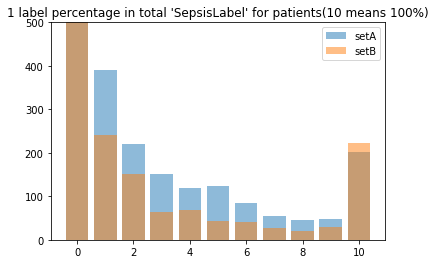

In [176]:
percentage_A = pd.DataFrame.from_dict(one_percentage_A, orient='index')
percentage_B = pd.DataFrame.from_dict(one_percentage_B, orient='index')
pA = plt.bar(percentage_A.index*10, percentage_A[0], label='line', alpha=0.5)
pB = plt.bar(percentage_B.index*10, percentage_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.ylim(ymax=500)
plt.title("1 label percentage in total 'SepsisLabel' for patients(10 means 100%)")

### ICU种类分布

In [204]:
unit1 = 0
unit2 = 0
unit3 = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if sum(tmp['Unit1'].fillna(0)) == len(tmp):
        unit1 += 1
    elif sum(tmp['Unit2'].fillna(0)) == len(tmp):
        unit2 += 1
    else:
        unit3 += 1

unit4 = 0
unit5 = 0
unit6 = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if sum(tmp['Unit1'].fillna(0)) == len(tmp):
        unit4 += 1
    elif sum(tmp['Unit2'].fillna(0)) == len(tmp):
        unit5 += 1
    else:
        unit6 += 1

Text(0.5, 1.0, 'ICU kind distribution')

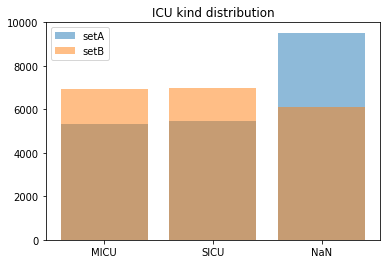

In [213]:
pA = plt.bar(['MICU', 'SICU', 'NaN'], [unit1, unit2, unit3], alpha=0.5)
pB = plt.bar(['MICU', 'SICU', 'NaN'], [unit4, unit5, unit6], alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title('ICU kind distribution')

### 性别分析

In [217]:
sex = [0 for _ in range(6)]
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if sum(tmp['Gender'].fillna(-1)) == 0:
        sex[0] += 1
    elif sum(tmp['Gender'].fillna(-1)) == len(tmp):
        sex[1] += 1
    else:
        sex[2] += 1

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if sum(tmp['Gender'].fillna(-1)) == 0:
        sex[3] += 1
    elif sum(tmp['Gender'].fillna(-1)) == len(tmp):
        sex[4] += 1
    else:
        sex[5] += 1

Text(0.5, 1.0, 'sex distribution')

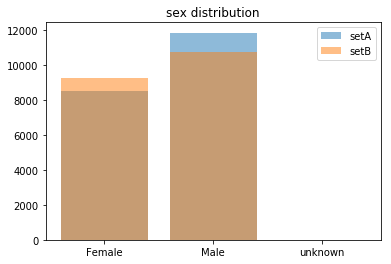

In [218]:
pA = plt.bar(['Female', 'Male', 'unknown'], sex[:3], alpha=0.5)
pB = plt.bar(['Female', 'Male', 'unknown'], sex[3:], alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title('sex distribution')

### 年龄分析

In [8]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

age_A = {}
for i in range(120):
    age_A[i] = 0
for i, csv in enumerate(tqdm(a_traincsv)):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    age = int(tmp['Age'][2])
    age_A[age] += 1

age_B = {}
for i in range(120):
    age_B[i] = 0
for i, csv in enumerate(tqdm(b_traincsv)):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    age = int(tmp['Age'][2])
    age_B[age] += 1

100%|██████████| 20000/20000 [01:04<00:00, 311.63it/s]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, 'age distribution')

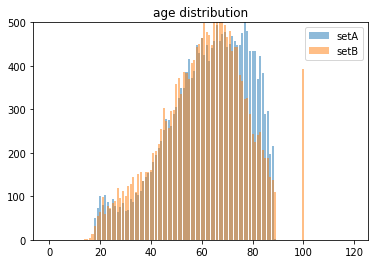

In [9]:
age_A = pd.DataFrame.from_dict(age_A, orient='index')
age_B = pd.DataFrame.from_dict(age_B, orient='index')
pA = plt.bar(age_A.index, age_A[0], label='line', alpha=0.5)
pB = plt.bar(age_B.index, age_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.ylim(ymax=500)
plt.title("age distribution")

B中最小的是14岁 A中最小的是18岁 B中有400多个100岁的

### 缺失度分析

In [239]:
train = pd.read_csv('./train.psv', sep='|')
train.shape

(1170446, 41)

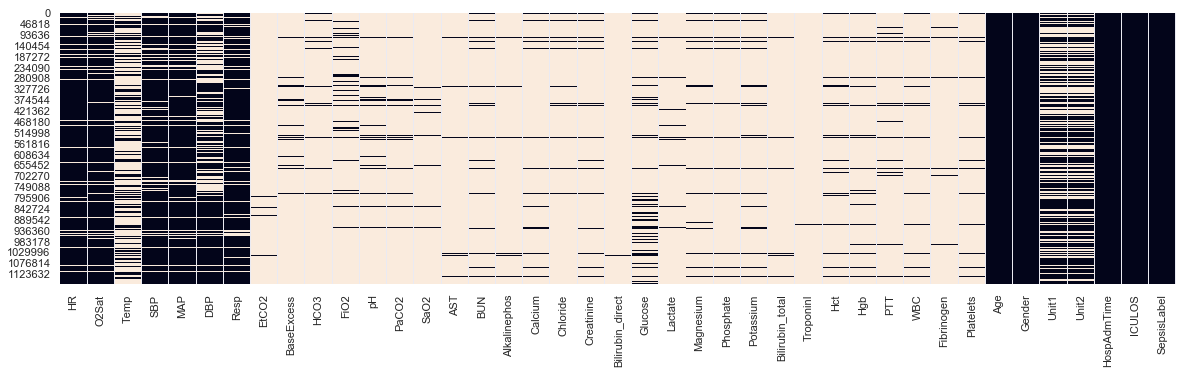

In [244]:
sns.set(rc={'figure.figsize': (20, 5)})
sns.heatmap(train.isnull(), cbar=False)

### 某检查与发病的关系

In [65]:
lab_values = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

In [110]:
a_traincsv = patient_a
b_traincsv = patient_b

distributionA = {}
for lab in lab_values:
    distributionA[lab] = []
for i, csv in enumerate(tqdm(a_traincsv)):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    gap = len(tmp[tmp['SepsisLabel'] == 0]) - 1
    for lab in lab_values:
        l = -1
        tmp[lab] = tmp[lab].fillna(-1)
        for index in range(1, len(tmp[lab])):
            
            if list(tmp[lab])[index] != -1 and list(tmp['SepsisLabel'])[index - 1] == 0:
                l = index
            if list(tmp['SepsisLabel'])[index - 1] == 0 and list(tmp['SepsisLabel'])[index] == 1:
                gap = max(-1, gap - l + 1)
                distributionA[lab].append(gap)
            
        

distributionB = {}
for lab in lab_values:
    distributionB[lab] = []
for i, csv in enumerate(tqdm(b_traincsv)):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    gap = len(tmp[tmp['SepsisLabel'] == 0]) - 1
    for lab in lab_values:
        l = -1
        tmp[lab] = tmp[lab].fillna(-1)
        for index in range(1, len(tmp[lab])):
            
            if list(tmp[lab])[index] != -1 and list(tmp['SepsisLabel'])[index - 1] == 0:
                l = index
            if list(tmp['SepsisLabel'])[index - 1] == 0 and list(tmp['SepsisLabel'])[index] == 1:
                gap = max(-1, gap - l + 1)
                distributionB[lab].append(gap)
            
        








  0%|          | 0/1790 [00:00<?, ?it/s]




  0%|          | 1/1790 [00:00<15:26,  1.93it/s]




  0%|          | 4/1790 [00:00<11:32,  2.58it/s]




  0%|          | 8/1790 [00:00<08:26,  3.52it/s]




  1%|          | 13/1790 [00:01<06:07,  4.84it/s]




  1%|          | 15/1790 [00:01<05:15,  5.63it/s]




  1%|          | 17/1790 [00:01<04:13,  7.00it/s]




  1%|          | 19/1790 [00:01<03:52,  7.61it/s]




  1%|          | 21/1790 [00:01<03:44,  7.88it/s]




  1%|▏         | 26/1790 [00:02<02:55, 10.06it/s]




  2%|▏         | 28/1790 [00:02<02:54, 10.10it/s]




  2%|▏         | 30/1790 [00:02<03:07,  9.41it/s]




  2%|▏         | 32/1790 [00:02<02:53, 10.11it/s]




  2%|▏         | 34/1790 [00:02<03:04,  9.52it/s]




  2%|▏         | 37/1790 [00:03<03:00,  9.73it/s]




  2%|▏         | 39/1790 [00:03<02:38, 11.06it/s]




  2%|▏         | 41/1790 [00:03<03:35,  8.13it/s]




  2%|▏         | 44/1790 [00:03<03:04,  9.47it/s]




  3%|▎         | 47/1790 [00:04<03:

 35%|███▍      | 620/1790 [00:53<01:43, 11.34it/s]




 35%|███▍      | 625/1790 [00:53<01:19, 14.63it/s]




 35%|███▌      | 628/1790 [00:53<01:37, 11.96it/s]




 35%|███▌      | 630/1790 [00:54<01:31, 12.73it/s]




 35%|███▌      | 632/1790 [00:54<02:16,  8.50it/s]




 35%|███▌      | 634/1790 [00:54<02:26,  7.90it/s]




 36%|███▌      | 636/1790 [00:55<03:18,  5.81it/s]




 36%|███▌      | 637/1790 [00:55<03:13,  5.97it/s]




 36%|███▌      | 638/1790 [00:55<03:02,  6.30it/s]




 36%|███▌      | 639/1790 [00:55<03:29,  5.49it/s]




 36%|███▌      | 640/1790 [00:56<03:27,  5.55it/s]




 36%|███▌      | 642/1790 [00:56<03:00,  6.37it/s]




 36%|███▌      | 643/1790 [00:56<03:27,  5.53it/s]




 36%|███▌      | 646/1790 [00:56<03:14,  5.89it/s]




 36%|███▌      | 648/1790 [00:57<02:41,  7.06it/s]




 36%|███▋      | 650/1790 [00:57<02:12,  8.62it/s]




 36%|███▋      | 652/1790 [00:57<02:02,  9.32it/s]




 37%|███▋      | 654/1790 [00:57<01:59,  9.51it/s]




 37%|███▋ 

 68%|██████▊   | 1221/1790 [01:44<00:55, 10.24it/s]




 68%|██████▊   | 1223/1790 [01:44<01:00,  9.33it/s]




 69%|██████▊   | 1227/1790 [01:44<00:49, 11.44it/s]




 69%|██████▊   | 1230/1790 [01:44<00:40, 13.85it/s]




 69%|██████▉   | 1232/1790 [01:44<00:38, 14.49it/s]




 69%|██████▉   | 1234/1790 [01:45<00:37, 14.77it/s]




 69%|██████▉   | 1236/1790 [01:45<00:35, 15.74it/s]




 69%|██████▉   | 1238/1790 [01:45<00:37, 14.84it/s]




 69%|██████▉   | 1240/1790 [01:45<00:43, 12.76it/s]




 69%|██████▉   | 1242/1790 [01:45<00:38, 14.20it/s]




 69%|██████▉   | 1244/1790 [01:45<00:37, 14.59it/s]




 70%|██████▉   | 1246/1790 [01:46<00:55,  9.74it/s]




 70%|██████▉   | 1249/1790 [01:46<00:46, 11.68it/s]




 70%|██████▉   | 1251/1790 [01:46<00:41, 12.87it/s]




 70%|███████   | 1253/1790 [01:46<00:38, 13.90it/s]




 70%|███████   | 1256/1790 [01:46<00:44, 12.06it/s]




 70%|███████   | 1259/1790 [01:47<00:42, 12.56it/s]




 71%|███████   | 1262/1790 [01:47<00:35, 14.74it

  0%|          | 2/1142 [00:00<04:35,  4.14it/s]




  0%|          | 4/1142 [00:00<03:39,  5.17it/s]




  1%|          | 6/1142 [00:00<03:00,  6.29it/s]




  1%|          | 9/1142 [00:01<02:20,  8.07it/s]




  1%|          | 12/1142 [00:01<01:54,  9.91it/s]




  1%|          | 14/1142 [00:01<01:51, 10.16it/s]




  1%|▏         | 16/1142 [00:01<02:25,  7.74it/s]




  2%|▏         | 18/1142 [00:01<02:10,  8.60it/s]




  2%|▏         | 20/1142 [00:02<02:17,  8.15it/s]




  2%|▏         | 22/1142 [00:02<02:42,  6.90it/s]




  2%|▏         | 23/1142 [00:02<02:46,  6.71it/s]




  2%|▏         | 24/1142 [00:02<02:42,  6.89it/s]




  2%|▏         | 27/1142 [00:03<02:54,  6.38it/s]




  3%|▎         | 29/1142 [00:03<02:31,  7.34it/s]




  3%|▎         | 33/1142 [00:03<01:56,  9.52it/s]




  3%|▎         | 36/1142 [00:04<01:47, 10.32it/s]




  3%|▎         | 38/1142 [00:04<01:36, 11.45it/s]




  4%|▎         | 40/1142 [00:04<01:26, 12.81it/s]




  4%|▎         | 42/1142 [00:04<

 53%|█████▎    | 610/1142 [00:55<00:51, 10.24it/s]




 54%|█████▎    | 612/1142 [00:55<00:50, 10.42it/s]




 54%|█████▍    | 615/1142 [00:55<00:44, 11.96it/s]




 54%|█████▍    | 617/1142 [00:55<00:53,  9.87it/s]




 54%|█████▍    | 620/1142 [00:56<01:05,  7.98it/s]




 54%|█████▍    | 622/1142 [00:56<00:59,  8.76it/s]




 55%|█████▍    | 625/1142 [00:56<00:50, 10.31it/s]




 55%|█████▍    | 628/1142 [00:56<00:40, 12.77it/s]




 55%|█████▌    | 630/1142 [00:57<01:07,  7.54it/s]




 55%|█████▌    | 633/1142 [00:58<01:30,  5.62it/s]




 56%|█████▌    | 636/1142 [00:58<01:27,  5.77it/s]




 56%|█████▌    | 639/1142 [00:58<01:06,  7.61it/s]




 56%|█████▌    | 641/1142 [00:59<01:03,  7.92it/s]




 56%|█████▋    | 644/1142 [00:59<01:22,  6.06it/s]




 57%|█████▋    | 646/1142 [01:00<01:12,  6.83it/s]




 57%|█████▋    | 648/1142 [01:00<00:59,  8.24it/s]




 57%|█████▋    | 650/1142 [01:00<01:04,  7.66it/s]




 57%|█████▋    | 652/1142 [01:00<00:53,  9.24it/s]




 57%|█████

In [111]:
distributionA_ = {}
distributionB_ = {}
for feature in distributionA:
    d = distributionA[feature]
    while -1 in d:
        d.remove(-1)
    distributionA_[feature] = sum(d)/len(d) if len(d) != 0 else 0
for feature in distributionB:
    d = distributionB[feature]
    while -1 in d:
        d.remove(-1)
    distributionB_[feature] = sum(d)/len(d) if len(d) != 0 else 0

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


([<matplotlib.axis.XTick at 0x1a28103cc0>,
 <a list of 26 Text xticklabel objects>)

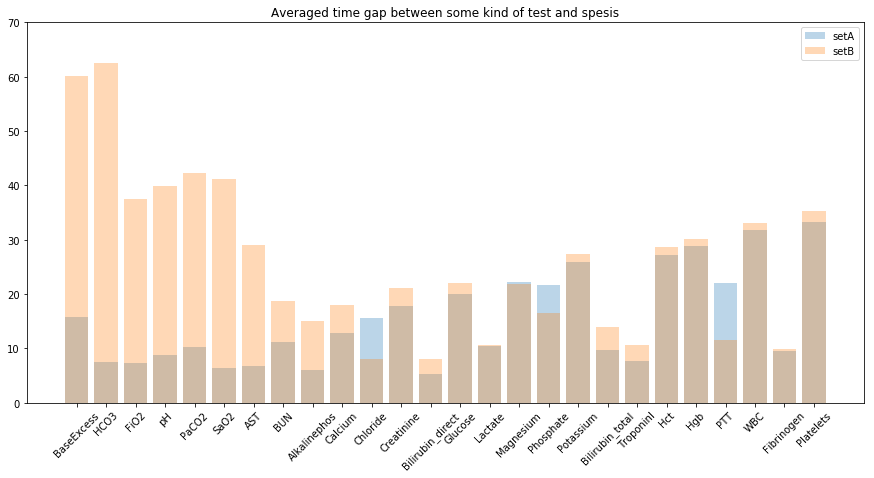

In [114]:
plt.figure(figsize=(15, 7))
length_A = pd.DataFrame.from_dict(distributionA_, orient='index')
length_B = pd.DataFrame.from_dict(distributionB_, orient='index')
pA = plt.bar(length_A.index[:100], length_A[0][:100], label='line', alpha=0.3)
pB = plt.bar(length_B.index[:100], length_B[0][:100], label='line', alpha=0.3)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.ylim(ymax=70)
plt.title("Averaged time gap between some kind of test and spesis")
plt.xticks(list(range(len(list(distributionA.keys())))), list(distributionA.keys()), rotation=45, fontsize=10)

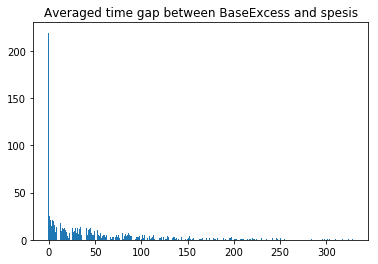

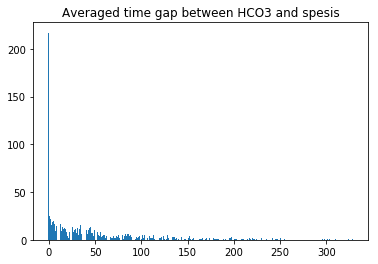

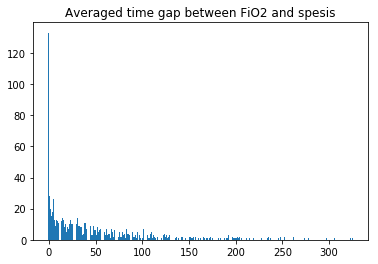

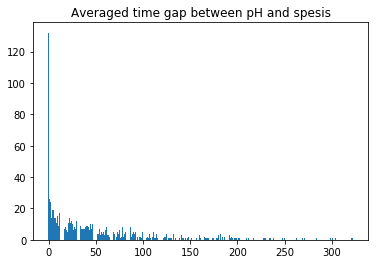

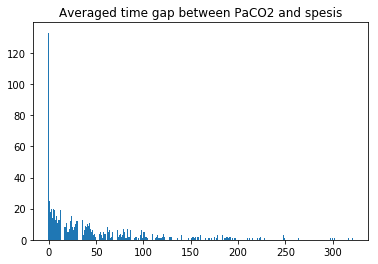

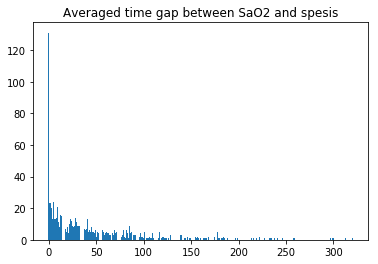

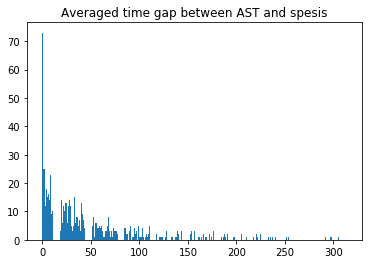

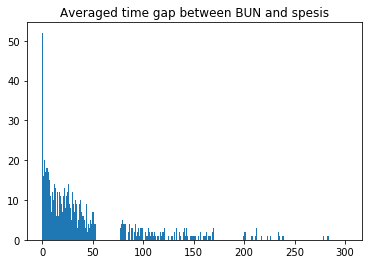

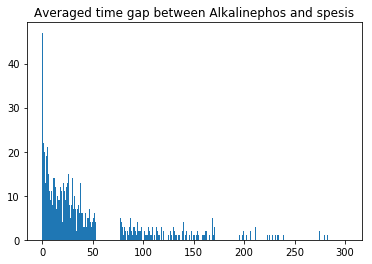

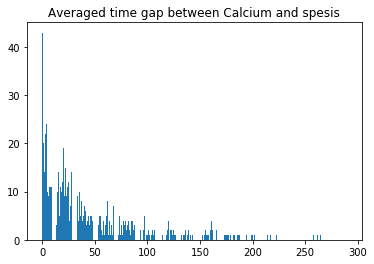

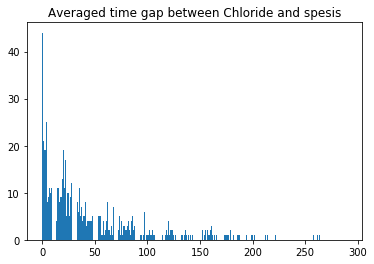

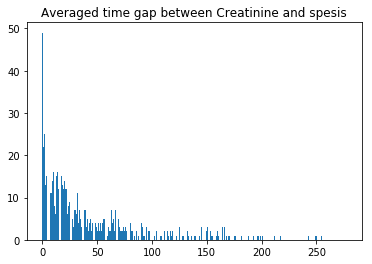

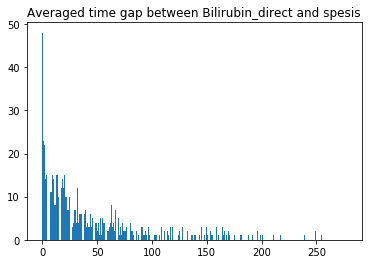

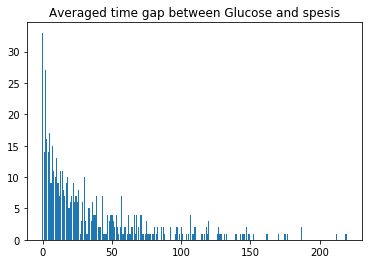

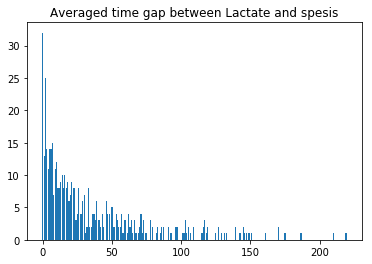

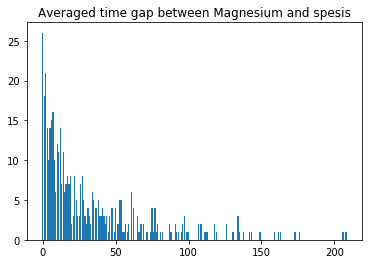

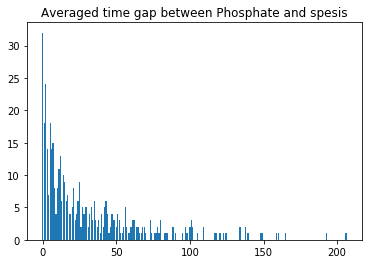

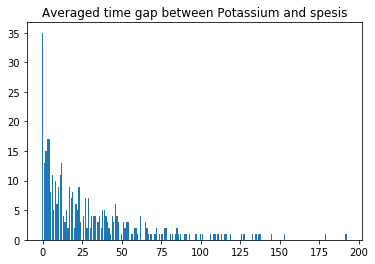

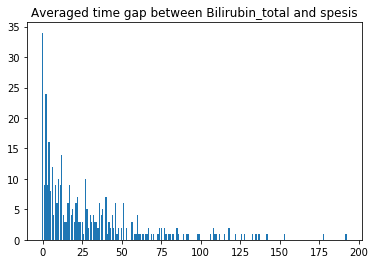

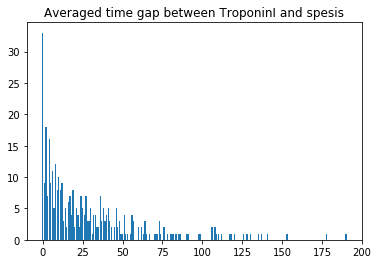

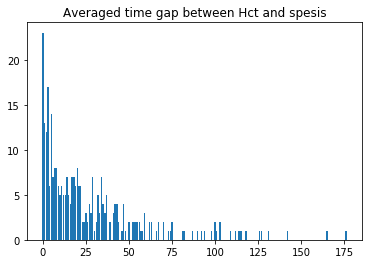

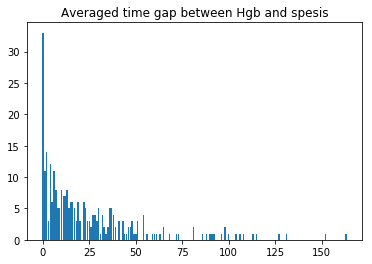

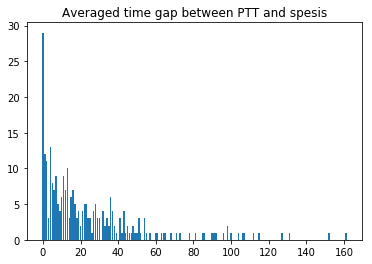

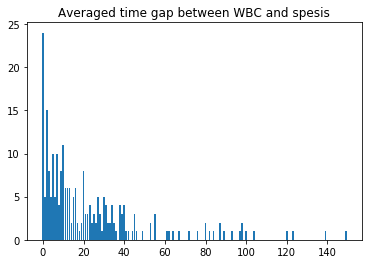

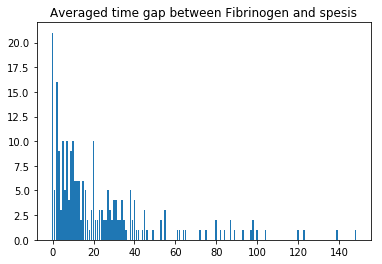

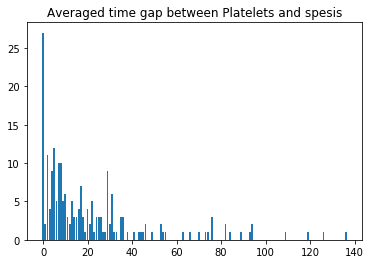

In [52]:
for i in range(len(lab_values)):
    plt.figure(i)
    plt.bar(list(Counter(distributionB[lab_values[i]])),(Counter(distributionB[lab_values[i]])).values())
    plt.title(f'Averaged time gap between {lab_values[i]} and spesis')
      

# Data processing

In [ ]:
train = pd.read_csv('./data/train.psv', sep='|')
len(train)

## Feature Engineering

### Vital Signs

##### Heart Rate

Heart rate for a healthy adult is between 60 and 100. For a healthy infant it is between 70 and 190. Creating a new feature custom_hr , which is categorical variable having three values Normal, Abnormal and Missing.

In [94]:
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),'custom_hr'] = 'abnormal'
    train['custom_hr'].fillna('Missing', inplace=True)
    return train

##### Temperature

Temperature for a healthy human being is between 36.4 degree C to 37.6 degree C.  Creating a new feature custom_temp , which is categorical variable having three values Normal, Abnormal and Missing

In [95]:
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 'custom_temp'] = 'abnormal'
    train['custom_temp'].fillna('Missing', inplace=True)
    return train


##### Age

Categorizing patient based on age to old, infant and Child/adult

In [126]:
def feature_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <10, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=10) & (train['Age'] <65), 'custom_age'] = 'adult'
    return train

##### O2Stat

O2Stat for a healthy adult is between 90 and 100 for healthy human beings. Create a new categorical variable custom_o2stat with levels normal, abnormal and missing

In [97]:
def feature_engineer_o2sat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 'custom_o2sat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 'custom_o2sat'] = 'abnormal'
    train['custom_o2sat'].fillna('Missing', inplace=True)
    return train


##### SBP DBP

SBP stands for Systolic blood pressure, It is the upper number while measuring Blood pressure.
DBP stands for Diastolic blood pressure , It is the lower number while measuring Blood pressure.
Using both these columns to categorize blood pressure as low, normal, elevated , high and missing

In [98]:
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'
    train.loc[(train['SBP'].between(90,120, inclusive=True)) & (train['DBP'].between(60,80, inclusive=True)), 'custom_bp'] = 'normal'
    train.loc[(train['SBP'].between(120,140, inclusive=True)) & (train['DBP'].between(80,90, inclusive=True)), 'custom_bp'] = 'elevated'
    train.loc[(train['SBP'] > 140 ) & (train['DBP'] > 90 ), 'custom_bp'] = 'high'
    train['custom_bp'].fillna('Missing', inplace=True)
    return train

##### Respiration Rate

Respiration rate for healthy adults is between 12 and 20. Categorizing respiratory rate as normal and abnormal based on thresholds.

In [99]:
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & (train['Age'] <1) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),'custom_resp'] = 'abnormal'
    train['custom_resp'].fillna('Missing', inplace=True)
    return train
  

##### EtCO2

Summary. End-tidal CO2 (EtCO2) monitoring is a noninvasive technique which measures the partial pressure or maximal concentration of carbon dioxide (CO2) at the end of an exhaled breath, which is expressed as a percentage of CO2 or mmHg. The normal values are 5% to 6% CO2, which is equivalent to 35-45 mmHg. 

In [100]:
def feature_engineer_etco2(train):
    train.loc[(train['EtCO2'] >= 35) & (train['EtCO2'] <=45), 'custom_etco2'] = 'normal'
    train.loc[(train['EtCO2'] < 35) & (train['EtCO2'] > 45), 'custom_etco2'] = 'abnormal'
    train['custom_etco2'].fillna('Missing', inplace=True)
    return train


### Laboratory values

##### BaseExcess

Base excess. Medical diagnostics. LOINC. 11555-0. In physiology, base excess and base deficit refer to an excess or deficit, respectively, in the amount of base present in the blood. -3 to 3 is normal range.

In [101]:
def feature_engineer_baseexcess(train):
    feature = 'BaseExcess'
    train.loc[(train['BaseExcess'] >= -3) & (train['BaseExcess'] <= 3), 'custom_etco2'] = 'normal'
    train.loc[(train['BaseExcess'] < -3) & (train['BaseExcess'] > 3), 'custom_etco2'] = 'abnormal'
    train['BaseExcess'].fillna('Missing', inplace=True)
    return train


##### HCO3

Partial pressure of carbon dioxide (PaCO2): 38 to 42 mm Hg (5.1 to 5.6 kPa) Arterial blood pH: 7.38 to 7.42. Oxygen saturation (SaO2): 94% to 100% Bicarbonate (HCO3): 22 to 28 milliequivalents per liter (mEq/L)

In [102]:
def feature_engineer_hco3(train):
    feature = 'HCO3'
    train.loc[(train[feature] >= -3) & (train[feature] <= 3), 'custom_hco3'] = 'normal'
    train.loc[(train[feature] < -3) & (train[feature] > 3), 'custom_hco3'] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    return train


##### FiO2 & SaO2

Partial pressure of oxygen (PaO2): 75 to 100 millimeters of mercury (mm Hg), or 10.5 to 13.5 kilopascal (kPa) 

SaO2: Normal arterial oxygen is approximately 75 to 100 millimeters of mercury (mm Hg). Values under 60 mm Hg usually indicate the need for supplemental oxygen. Normal pulse oximeter readings usually range from 95 to 100 percent. Values under 90 percent are considered low

FiO2: Normal range (PaO2/FiO2): = 400

In [103]:
def feature_engineer_fso2(train):
    feature = 'FiO2'
    feature_ = 'SaO2'
    custom = 'custom_fio2'
    custom_ = 'custom_sao2'
    
    train.loc[(train[feature] >= 0.18) & (train[feature] <= 0.25), custom] = 'normal'
    train.loc[(train[feature] < 0.18) & (train[feature] > 0.25), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= 94) & (train[feature_] <= 100), custom_] = 'normal'
    train.loc[(train[feature_] < 94) & (train[feature_] > 100), custom_] = 'abnormal'
    
    train[feature].fillna('Missing', inplace=True)
    train[feature_].fillna('Missing', inplace=True)
    return train


##### PaCO2

Partial pressure of carbon dioxide (PaCO2): 38 to 42 mm Hg (5.1 to 5.6 kPa) Arterial blood pH: 7.38 to 7.42. 

大于50酸中毒

In [128]:
def feature_engineer_paco2(train):
    feature = 'PaCO2'
    train.loc[(train[feature] >= 38) & (train[feature] <= 42), 'custom_paco2'] = 'normal'
    train.loc[(train[feature] < 38) & (train[feature] > 42) & (train[feature] <= 50), 'custom_paco2'] = 'abnormal'
    train.loc[(train[feature] > 50), 'custom_paco2'] = 'serious'
    train[feature].fillna('Missing', inplace=True)
    return train


##### pH

血液酸碱度即血液内氢离子浓度的负对数值，一般以pH值作为指标，正常人血液的酸碱度保持相对恒定，变动范围在7.35～7.45之间。

In [105]:
def feature_engineer_ph(train):
    feature = 'pH'
    train.loc[(train[feature] >= 7.35) & (train[feature] <= 7.45), 'custom_ph'] = 'normal'
    train.loc[(train[feature] < 7.35) & (train[feature] > 7.45), 'custom_ph'] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    return train


##### AST

The reference range for aspartate aminotransferase (AST) is as follows: Males: 6-34 IU/L. Females: 8-40 IU/L

In [139]:
def feature_engineer_ast(train):
    feature = 'AST'
    up = 34
    down = 6
    up_ = 40
    down_ = 8
    
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down_) & (train[feature] > up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    return train


##### BUN

In general, around 7 to 20 mg/dL (2.5 to 7.1 mmol/L) is considered normal. But normal ranges may vary, depending on the reference range used by the lab, and your age. Ask your doctor to explain your results. Urea nitrogen levels tend to increase with age.

In [131]:
def feature_engineer_bun(train):
    feature = 'BUN'
    up = 20
    down = 7
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Alkalinephos

The normal range is 44 to 147 international units per liter (IU/L) or 0.73 to 2.45 microkatal per liter (µkat/L). Normal values may vary slightly from laboratory to laboratory. They also can vary with age and gender. High levels of ALP are normally seen in children undergoing growth spurts and in pregnant women.

In [108]:
def feature_engineer_alkalinephos(train):
    feature = 'Alkalinephos'
    up = 147
    down = 44
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Calcium

The corrected total serum calcium concentration is normally 8.5-10.2 mg/dL, but there is no sure means of predicting the serum calcium level, for either hypocalcemia or hypercalcemia, at which symptoms will occur. The rapidity of change, as well as the absolute serum calcium concentration, impacts symptom development.

In [109]:
def feature_engineer_calcium(train):
    feature = 'Calcium'
    up = 10.2
    down = 8.5
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Chloride

Chloride daily requirements for adults are 80-120 mEq/d as NaCL. The reference range for chloride is as follows: Normal range: 98-106 mmol/L. Critical values: < 70 or >120 mmol/L

In [110]:
def feature_engineer_chloride(train):
    feature = 'Chloride'
    up = 98
    down = 106
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] >= 70) & (train[feature] < down) & (train[feature] > up & (train[feature] <= 120)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < 70) & (train[feature] > 120), 'custom_' + feature.lower()] = 'serious'

    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Creatinine

The kidneys are responsible for keeping the level of creatinine in the blood within a normal range. The typical reference range for serum creatinine is 60 to 110 micromoles per liter (mmol/L) (0.7 to 1.2 milligrams per deciliter (mg/dL)) for men and 45 to 90 mmol/L (0.5 to 1.0 mg/dL) for women.

In [111]:
def feature_engineer_creatinine(train):
    feature = 'Creatinine'
    up = 0.7
    down = 1.2
    up_ = 0.5
    down_ = 1.0
    
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down_) & (train[feature] > up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    return train


##### Bilirubin

It is normal to have some bilirubin in the blood. A normal level is: Direct (also called conjugated) bilirubin: less than 0.3 mg/dL (less than 5.1 µmol/L) Total bilirubin: 0.1 to 1.2 mg/dL (1.71 to 20.5 µmol/L)

In [112]:
def feature_engineer_bilirubin(train):
    feature = 'Bilirubin_direct'
    feature_ = 'Bilirubin_total'
    custom = 'custom_bd'
    custom_ = 'custom_bt'
    up = 0.3
    down = -1000
    up_ = 1.2
    down_ = 0.1
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), custom] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= down_) & (train[feature_] <= up_), custom_] = 'normal'
    train.loc[(train[feature_] < down_) & (train[feature_] > up_), custom_] = 'abnormal'
    
    train[feature].fillna('Missing', inplace=True)
    train[feature_].fillna('Missing', inplace=True)
    return train


##### Glucose

A fasting blood sugar level from 100 to 125 mg/dL (5.6 to 6.9 mmol/L) is considered prediabetes. If it's 126 mg/dL (7 mmol/L) or higher on two separate tests, you have diabetes. Oral glucose tolerance test. ... A reading of more than 200 mg/dL (11.1 mmol/L) after two hours indicates diabetes.

In [113]:
def feature_engineer_glucose(train):
    feature = 'Glucose'
    up = 125
    down = 100
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Lactate

Based on this pathophysiology, new definition of septic shock can be explained although serum lactate level of 2 mmol/L (18.2 mg/dL) is normal value. Therefore, if a patient has a serum lactate level >2 mmol/L, BP or serum lactate level should be carefully monitored.

The normal blood lactate concentration in unstressed patients is 0.5-1 mmol/L. Patients with critical illness can be considered to have normal lactate concentrations of less than 2 mmol/L. Hyperlactatemia is defined as a mild to moderate persistent increase in blood lactate concentration (2-4 mmol/L) without metabolic

In [114]:
def feature_engineer_lactate(train):
    feature = 'Lactate'
    up = 18.2
    down = 4.55
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Magnesium

The normal range for blood magnesium level is 1.7 to 2.2 mg/dL (0.85 to 1.10 mmol/L). Normal value ranges may vary slightly among different laboratories.

In [115]:
def feature_engineer_magnesium(train):
    feature = 'Magnesium'
    up = 1.1
    down = 0.85
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Phosphorus

Serum phosphorus is measured in milligrams of phosphorus per deciliter of blood (mg/dL). According to Mayo Medical Laboratories, a normal range for adults is generally 2.5 to 4.5 mg/dL. The normal range varies slightly depending on your age.

In [116]:
def feature_engineer_phosphorus(train):
    feature = 'Phosphorus'
    up = 4.5
    down = 2.5
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Potassium

Your blood potassium level is normally 3.6 to 5.2 millimoles per liter (mmol/L). Having a blood potassium level higher than 6.0 mmol/L can be dangerous and usually requires immediate treatment.

In [117]:
def feature_engineer_potassium(train):
    feature = 'Potassium'
    up = 5.2
    down = 3.6
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up) & (train[feature] <= 6), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] > 6), 'custom_' + feature.lower()] = 'serious'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Troponin

Results are given in nanograms per milliliter (ng/mL). The normal range for troponin is between 0 and 0.4 ng/mL. Other types of heart injury may cause a rise in troponin levels. ... Damage to the heart from anthracycline medicines.

In [146]:
def feature_engineer_troponin(train):
    feature = 'TroponinI'
    up = 0.4
    down = 0
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Hct

This is the ratio of the volume of red cells to the volume of whole blood. Normal range for hematocrit is different between the sexes and is approximately 45% to 52% for men and 37% to 48% for women.

In [119]:
def feature_engineer_hct(train):
    feature = 'Hct'
    up = 52
    down = 45
    up_ = 48
    down_ = 37
    
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down_) & (train[feature] > up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)

    return train


##### Hgb

The normal range for hemoglobin is: For men, 13.5 to 17.5 grams per deciliter. For women, 12.0 to 15.5 grams per deciliter.

In [120]:
def feature_engineer_hgb(train):
    feature = 'Hgb'
    up = 17.5
    down = 13.5
    up_ = 15.5
    down_ = 12
    
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down_) & (train[feature] > up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    
    return train


##### PTT

PTT test results are measured in seconds. Normal results are typically 25 to 35 seconds. This means that it took your blood sample 25 to 35 seconds to clot after adding the chemicals.

In [121]:
def feature_engineer_ptt(train):
    feature = 'PTT'
    up = 35
    down = 25
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### WBC

The normal number of WBCs in the blood is 4,500 to 11,000 WBC per microliter (4.5 to 11.0 ÃƒÂ— 109/L). Normal value ranges may vary slightly among different labs. Some labs use different measurements or may test different specimens. Talk to your provider about your test results

In [122]:
def feature_engineer_wbc(train):
    feature = 'WBC'
    up = 11
    down = 4.5
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Fibrinogen

Fibrinogen is a soluble protein in the plasma that is broken down to fibrin by the enzyme thrombin to form clots. The reference range for the different fibrinogen tests are as follows: Fibrinogen antigen: 149-353 mg/dL. Fibrinogen: 150-400 mg/dL.

In [123]:
def feature_engineer_fibrinogen(train):
    feature = 'Fibrinogen'
    up = 400
    down = 150
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


##### Platelets

The normal number of platelets in the blood is 150,000 to 400,000 platelets per microliter (mcL) or 150 to 400 ÃƒÂ— 109/L. Normal value ranges may vary slightly. Some lab use different measurements or may test different specimens. Talk to your doctor about your test results.

In [124]:
def feature_engineer_platelets(train):
    feature = 'Platelets'
    up = 400
    down = 150
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) & (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[feature].fillna('Missing', inplace=True)
    
    return train


### Transform

In [148]:
# train = pd.read_csv('./data/train.psv', sep='|')

# train = feature_engineer_age(train)
# train = feature_engineer_blood_pressure(train)
# train = feature_engineer_hr(train)
# train = feature_engineer_o2sat(train)
# train = feature_engineer_temp(train)
# train = feature_engineer_resp_rate(train)
# train = feature_engineer_etco2(train)

# train = feature_engineer_baseexcess(train)
# train = feature_engineer_hco3(train)
# train = feature_engineer_fso2(train)
# train = feature_engineer_ph(train)
# train = feature_engineer_paco2(train)
# train = feature_engineer_ast(train)
# train = feature_engineer_bun(train)
# train = feature_engineer_alkalinephos(train)
# train = feature_engineer_calcium(train)
# train = feature_engineer_chloride(train)
# train = feature_engineer_creatinine(train)
# train = feature_engineer_bilirubin(train)
# train = feature_engineer_glucose(train)
# train = feature_engineer_lactate(train)
# train = feature_engineer_magnesium(train)
# train = feature_engineer_potassium(train)
#train = feature_engineer_troponin(train)
#train = feature_engineer_hct(train)
train = feature_engineer_hgb(train)
train = feature_engineer_ptt(train)
train = feature_engineer_wbc(train)
train = feature_engineer_fibrinigen(train)
train = feature_engineer_platelets(train)


TypeError: '>=' not supported between instances of 'str' and 'int'

# Pre_classification

In [136]:
encoder = LabelEncoder()
custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
for c in custom_vital:
    tmp = train[c]
    tmp[0:len(tmp)] = encoder.fit_transform(tmp[0:len(tmp)])
    train[c] = tmp


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [138]:
vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']

# 导入数据
data = train
flag = train

# 训练集和测试集
data_1 = train[train['SepsisLabel'] == 1][custom_vital]
data_0 = train[train['SepsisLabel'] == 0][custom_vital]
flag_1 = train[train['SepsisLabel'] == 1]['SepsisLabel']
flag_0 = train[train['SepsisLabel'] == 0]['SepsisLabel']

np.random.seed(seed=3)
data_0 = data_0.sample(len(data_1),replace=False)
flag_0 = flag_0.sample(len(data_1),replace=False)
data = data_1.append(data_0)
flag = flag_1.append(flag_0)
train_x, test_x, train_y, test_y = train_test_split(
    data, 
    flag, 
    test_size=0.3,
    random_state=0, 
    stratify=flag ## 这里保证分割后y的比例分布与原数据一致
)


### XGBOOST

[0]	train-auc:0.612581
[1]	train-auc:0.622249
[2]	train-auc:0.625868
[3]	train-auc:0.625054
[4]	train-auc:0.624776


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[5]	train-auc:0.62566
[6]	train-auc:0.625124
[7]	train-auc:0.62522
[8]	train-auc:0.626005
[9]	train-auc:0.627316
[10]	train-auc:0.627066
[11]	train-auc:0.627258
[12]	train-auc:0.627366
[13]	train-auc:0.627278
[14]	train-auc:0.627836
[15]	train-auc:0.628122
[16]	train-auc:0.627873
[17]	train-auc:0.627879
[18]	train-auc:0.628086
[19]	train-auc:0.628015
[20]	train-auc:0.627905
[21]	train-auc:0.627788
[22]	train-auc:0.628002
[23]	train-auc:0.628057
[24]	train-auc:0.627795
[25]	train-auc:0.627986
[26]	train-auc:0.628221
[27]	train-auc:0.628188
[28]	train-auc:0.628131
[29]	train-auc:0.62807
[30]	train-auc:0.628522
[31]	train-auc:0.628562
[32]	train-auc:0.628577
[33]	train-auc:0.628528
[34]	train-auc:0.628705
[35]	train-auc:0.628866
[36]	train-auc:0.6288
[37]	train-auc:0.628569
[38]	train-auc:0.628519
[39]	train-auc:0.628541
[40]	train-auc:0.628619
[41]	train-auc:0.628705
[42]	train-auc:0.628637
[43]	train-auc:0.628665
[44]	train-auc:0.628565
[45]	train-auc:0.628686
[46]	train-auc:0.628856
[4

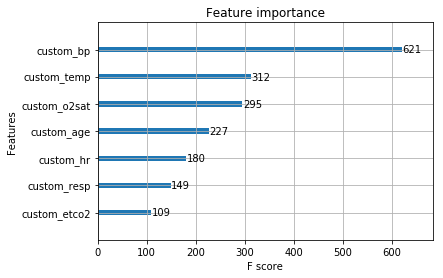

In [139]:
# 模型初始化设置
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x)

# booster:
params = {'booster': 'gbtree',
          'objective': 'binary:logistic',
          'eval_metric': 'auc',
          'max_depth': 7,
          'lambda': 15,
          'subsample': 0.75,
          'colsample_bytree': 0.75,
          'min_child_weight': 1,
          'eta': 0.025,
          'seed': 0,
          'nthread': 8,
          'silent': 1,
          'gamma': 0.15,
          'learning_rate': 0.01}

watchlist = [(dtrain, 'train')]

# 建模与预测:NUM_BOOST_round迭代次数和数的个数一致
bst = xgb.train(params, dtrain, num_boost_round=50, evals=watchlist)
ypred = bst.predict(dtest)

# 设置阈值, 输出一些评价指标，>0.5预测为1，其他预测为0
y_pred = (ypred >= 0.44)*1

print('AUC: %.4f' % metrics.roc_auc_score(test_y, ypred))
print('ACC: %.4f' % metrics.accuracy_score(test_y, y_pred))
print('Recall: %.4f' % metrics.recall_score(test_y, y_pred))
print('F1-score: %.4f' % metrics.f1_score(test_y, y_pred))
print('Precesion: %.4f' % metrics.precision_score(test_y, y_pred))
metrics.confusion_matrix(test_y, y_pred)


mpl.rcParams['font.sans-serif'] = ['SimHei']
xgb.plot_importance(bst)

In [140]:
for t in range(10,100):
    y_pred = (ypred >= t/100)*1
    print(t/100)
    print('AUC: %.4f' % metrics.roc_auc_score(test_y, ypred))
    print('ACC: %.4f' % metrics.accuracy_score(test_y, y_pred))
    print('Recall: %.4f' % metrics.recall_score(test_y, y_pred))
    print('F1-score: %.4f' % metrics.f1_score(test_y, y_pred))
    print('Precesion: %.4f' % metrics.precision_score(test_y, y_pred))

0.1
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.11
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.12
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.13
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.14
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.15
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.16
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.17
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.18
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.19
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.2
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.21
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.22
AUC: 0.6311
ACC: 0.5000
Recall: 1.0000
F1-score: 

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F

F1-score: 0.0000
Precesion: 0.0000
0.7
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.71
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.72
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.73
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.74
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.75
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.76
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.77
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.78
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.79
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.8
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.81
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.82
AUC: 0.6311
AC

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F

AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.84
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.85
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.86
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.87
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.88
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.89
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.9
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.91
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.92
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.93
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.94
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.0000
Precesion: 0.0000
0.95
AUC: 0.6311
ACC: 0.5000
Recall: 0.0000
F1-score: 0.00

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: P

### LGBM

Start training...
[1]	valid_0's auc: 0.580089	valid_0's binary_logloss: 0.690986
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.586621	valid_0's binary_logloss: 0.68877
[3]	valid_0's auc: 0.590867	valid_0's binary_logloss: 0.686906
[4]	valid_0's auc: 0.590507	valid_0's binary_logloss: 0.685434
[5]	valid_0's auc: 0.601238	valid_0's binary_logloss: 0.683892
[6]	valid_0's auc: 0.602136	valid_0's binary_logloss: 0.68264
[7]	valid_0's auc: 0.603441	valid_0's binary_logloss: 0.681049
[8]	valid_0's auc: 0.60605	valid_0's binary_logloss: 0.679702
[9]	valid_0's auc: 0.612589	valid_0's binary_logloss: 0.67867
[10]	valid_0's auc: 0.614531	valid_0's binary_logloss: 0.677961
[11]	valid_0's auc: 0.615976	valid_0's binary_logloss: 0.677004
[12]	valid_0's auc: 0.615293	valid_0's binary_logloss: 0.676419
[13]	valid_0's auc: 0.621588	valid_0's binary_logloss: 0.675809
[14]	valid_0's auc: 0.620658	valid_0's binary_logloss: 0.675351
[15]	valid_0's auc: 0.621444	valid_0

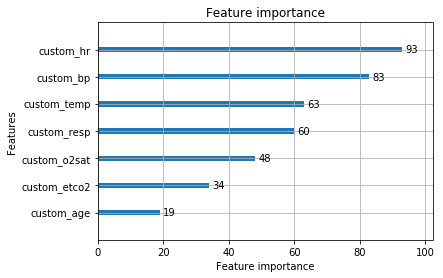

In [143]:
test_X, val_x, test_Y, val_y = train_test_split(
    test_x, 
    test_y, 
    test_size=0.25,
    random_state=0, 
    stratify=test_y ## 这里保证分割后y的比例分布与原数据一致
)

X_train = train_x
y_train = train_y

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)


# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_leaves': 5,
    'max_depth': 6,
    'min_data_in_leaf': 450,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'lambda_l1': 1,  
    'lambda_l2': 0.001,  # 越小l2正则程度越高
    'min_gain_to_split': 0.2,
    'verbose': 5,
    'is_unbalance': True
}
 
# train
print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=100)
 
print('Start predicting...')
 
preds = gbm.predict(test_X, num_iteration=gbm.best_iteration)  # 输出的是概率


y_pred = (preds >= 0.33)*1

print('AUC: %.4f' % metrics.roc_auc_score(test_Y, y_pred))
print('ACC: %.4f' % metrics.accuracy_score(test_Y, y_pred))
print('Recall: %.4f' % metrics.recall_score(test_Y, y_pred))
print('F1-score: %.4f' % metrics.f1_score(test_Y, y_pred))
print('Precesion: %.4f' % metrics.precision_score(test_Y, y_pred))
metrics.confusion_matrix(test_Y, y_pred)

# 绘制特征重要性

lgb.plot_importance(gbm)

In [142]:
for t in range(10,100):
    y_pred = (preds >= t/100)*1
    print(t/100)
    print('AUC: %.4f' % metrics.roc_auc_score(test_Y, y_pred))
    print('ACC: %.4f' % metrics.accuracy_score(test_Y, y_pred))
    print('Recall: %.4f' % metrics.recall_score(test_Y, y_pred))
    print('F1-score: %.4f' % metrics.f1_score(test_Y, y_pred))
    print('Precesion: %.4f' % metrics.precision_score(test_Y, y_pred))

0.1
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.11
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.12
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.13
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.14
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.15
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.16
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.17
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.18
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.19
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.2
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.21
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.22
AUC: 0.5000
ACC: 0.5000
Recall: 1.0000
F1-score: 

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F

### cut